## S/N budget estimator and exposure time calculator, adapted from Turyshev2025

[Script enhancements and clean-up aided by Microsoft Copilot and ChatGPT]

### Utilities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.transforms as mtransforms
from matplotlib.ticker import FuncFormatter, NullFormatter
import formatter

In [2]:
# Fundamental physical constants

h = 6.62607015e-34    # [J s ≡ J Hz^-1 ≡ kg m^2 s^-1] Planck's constant
c = 299792458.        # [m/s] Light speed in vacuum


# Useful conversion factors

arcsec_per_radian = 60. * 60. * 180. / np.pi

### Functional definitions

In [3]:
def F_0_V(F_lambda_0_W_m_2_nm_1=3.631e-11, lam_nm=550.):

    """Adapted from Eq. (7) of Turyshev2025.
       V-band spectral flux density zero point for calibration from: https://www.astronomy.ohio-state.edu/martini.10/usefuldata.html."""

    lam_m = lam_nm * 1.e-9
    F_0_V_photons_m_2_s_1_nm_1 = F_lambda_0_W_m_2_nm_1 * lam_m / (h * c)

    return F_0_V_photons_m_2_s_1_nm_1


print(f"V-band spectral photon flux density zero point for calibration: F_0_V = {F_0_V():.6e} photons m^-2 s^-1 nm^-1")

V-band spectral photon flux density zero point for calibration: F_0_V = 1.005338e+08 photons m^-2 s^-1 nm^-1


In [4]:
def apparent_magnitude_to_flux(F_0point, mag):

    return F_0point * 10.**(-0.4 * mag)

In [5]:
def diameter_to_area(D_m):

    return np.pi * (.5 * D_m)**2.

def area_to_diameter(A_m2):

    return 2. * np.sqrt(A_m2 / np.pi)

#### Signal estimation

In [6]:
def F_exoworld(F_0_V_photons_m_2_s_1_nm_1, mV_exoworld=27.77):

    """Adapted from Eq. (8) of Turyshev2025."""

    F_exoworld_photons_m_2_s_1_nm_1 = apparent_magnitude_to_flux(F_0_V_photons_m_2_s_1_nm_1, mV_exoworld)

    return F_exoworld_photons_m_2_s_1_nm_1


print(f"Spectral flux density from an exoworld with a V-band apparent magnitude = {27.77}: F_exoworld = {F_exoworld(F_0_V()):.6e} photons m^-2 s^-1 nm^-1")

Spectral flux density from an exoworld with a V-band apparent magnitude = 27.77: F_exoworld = 7.839930e-04 photons m^-2 s^-1 nm^-1


In [7]:
def photon_flux_exoworld(F_0_V_photons_m_2_s_1_nm_1, mV_exoworld=27.77, A_m2=100., dlam_nm=50.):

    """Adapted from Eq. (9) of Turyshev2025."""

    photon_flux_exoworld_photons_m_2_s_1_nm_1 = F_exoworld(F_0_V_photons_m_2_s_1_nm_1, mV_exoworld) * A_m2 * dlam_nm

    return photon_flux_exoworld_photons_m_2_s_1_nm_1


print(f"Photon flux from an exoworld with a V-band apparent magnitude = {27.77}, a light-gathering area = {100.} m^2, in a spectral bandwidth = {50.} nm: F_exoworld = {photon_flux_exoworld(F_0_V())} photons s^-1")

#####

photon_flux_exoworld_photons_m_2_s_1_nm_1_pixel_1 = photon_flux_exoworld(F_0_V()) / 100.


print(f"Photon flux per pixel of a 10x10-pixel surface map from an exoworld with a V-band apparent magnitude = {27.77}, a light-gathering area = {100.} m^2, in a spectral bandwidth = {50.} nm: F_exoworld = {photon_flux_exoworld_photons_m_2_s_1_nm_1_pixel_1:.6e} photons s^-1 pixel^-1")

Photon flux from an exoworld with a V-band apparent magnitude = 27.77, a light-gathering area = 100.0 m^2, in a spectral bandwidth = 50.0 nm: F_exoworld = 3.919965189626896 photons s^-1
Photon flux per pixel of a 10x10-pixel surface map from an exoworld with a V-band apparent magnitude = 27.77, a light-gathering area = 100.0 m^2, in a spectral bandwidth = 50.0 nm: F_exoworld = 3.919965e-02 photons s^-1 pixel^-1


#### Astrophysical backgrounds

In [8]:
def F_zodi(F_0_V_photons_m_2_s_1_nm_1, mV_zodi_arcsec_2=23.):

    """Adapted from Turyshev2025."""

    F_zodi_photons_m_2_s_1_nm_1_arcsec_2 = apparent_magnitude_to_flux(F_0_V_photons_m_2_s_1_nm_1, mV_zodi_arcsec_2)

    return F_zodi_photons_m_2_s_1_nm_1_arcsec_2


print(f"Spectral flux density from the local zodiacal light (from interplanetary dust within the Solar System) with a V-band apparent magnitude = {23.} arcsec^-2: F_zodi = {F_zodi(F_0_V()):.6e} photons m^-2 s^-1 nm^-1 arcsec^-2")

Spectral flux density from the local zodiacal light (from interplanetary dust within the Solar System) with a V-band apparent magnitude = 23.0 arcsec^-2: F_zodi = 6.343256e-02 photons m^-2 s^-1 nm^-1 arcsec^-2


In [9]:
def F_exozodi(F_0_V_photons_m_2_s_1_nm_1, mV_zodi_arcsec_2=23., exozodi_factor=8.):

    """Adapted from Turyshev2025.
       Assuming 8 times the Solar System's zodiacal cloud, from the 5--8 upper limit factor for a disk coplanar with the α Cen AB orbit, as reported by Beichman+2025 and Sanghi+2025."""

    F_exozodi_photons_m_2_s_1_nm_1_arcsec_2 = exozodi_factor * apparent_magnitude_to_flux(F_0_V_photons_m_2_s_1_nm_1, mV_zodi_arcsec_2)

    return F_exozodi_photons_m_2_s_1_nm_1_arcsec_2


print(f"Spectral flux density from an exozodiacal (circumstellar) dust belt with a V-band apparent magnitude = {23.} arcsec^-2: F_exozodi = {F_exozodi(F_0_V())} photons m^-2 s^-1 nm^-1 arcsec^-2")

Spectral flux density from an exozodiacal (circumstellar) dust belt with a V-band apparent magnitude = 23.0 arcsec^-2: F_exozodi = 0.5074604415758602 photons m^-2 s^-1 nm^-1 arcsec^-2


In [10]:
def F_diffuse_Milky_Way(F_0_V_photons_m_2_s_1_nm_1, mV_MilkyWay_arcsec_2=24.):

    """Adapted from Turyshev2025."""

    F_MilkyWay_photons_m_2_s_1_nm_1_arcsec_2 = apparent_magnitude_to_flux(F_0_V_photons_m_2_s_1_nm_1, mV_MilkyWay_arcsec_2)

    return F_MilkyWay_photons_m_2_s_1_nm_1_arcsec_2


print(f"Spectral flux density from scattered interstellar dust within the Milky Way with a V-band apparent magnitude = {24.} arcsec^-2: F_diffuse_Milky_Way = {F_diffuse_Milky_Way(F_0_V()):.6e} photons m^-2 s^-1 nm^-1 arcsec^-2")

Spectral flux density from scattered interstellar dust within the Milky Way with a V-band apparent magnitude = 24.0 arcsec^-2: F_diffuse_Milky_Way = 2.525296e-02 photons m^-2 s^-1 nm^-1 arcsec^-2


In [11]:
def F_extragalactic_background(F_0_V_photons_m_2_s_1_nm_1, mV_extragalactic_arcsec_2=26.5):

    """Adapted from Turyshev2025."""

    F_extragalactic_photons_m_2_s_1_nm_1_arcsec_2 = apparent_magnitude_to_flux(F_0_V_photons_m_2_s_1_nm_1, mV_extragalactic_arcsec_2)

    return F_extragalactic_photons_m_2_s_1_nm_1_arcsec_2


print(f"Spectral flux density from the integrated extragalactic isotropic background light emission (from unresolved galaxies) with a V-band apparent magnitude = {26.5} arcsec^-2: F_extragalactic_background = {F_extragalactic_background(F_0_V()):.6e} photons m^-2 s^-1 nm^-1 arcsec^-2")

Spectral flux density from the integrated extragalactic isotropic background light emission (from unresolved galaxies) with a V-band apparent magnitude = 26.5 arcsec^-2: F_extragalactic_background = 2.525296e-03 photons m^-2 s^-1 nm^-1 arcsec^-2


In [12]:
def F_unresolved_MW_starlight(F_0_V_photons_m_2_s_1_nm_1, mV_unresolved_MW_starlight=27.5):

    """Adapted from Turyshev2025."""

    F_unresolved_stars_photons_m_2_s_1_nm_1_arcsec_2 = apparent_magnitude_to_flux(F_0_V_photons_m_2_s_1_nm_1, mV_unresolved_MW_starlight)

    return F_unresolved_stars_photons_m_2_s_1_nm_1_arcsec_2


print(f"Spectral flux density from unresolved Milky-Way stars with a V-band apparent magnitude = {27.5} arcsec^-2: F_unresolved_MW_starlight = {F_unresolved_MW_starlight(F_0_V()):.6e} photons m^-2 s^-1 nm^-1 arcsec^-2")

Spectral flux density from unresolved Milky-Way stars with a V-band apparent magnitude = 27.5 arcsec^-2: F_unresolved_MW_starlight = 1.005338e-03 photons m^-2 s^-1 nm^-1 arcsec^-2


In [13]:
def F_unresolved_extragalactic_point_sources(F_0_V_photons_m_2_s_1_nm_1, mV_unresolved_extragalactic_point_sources=28.):

    """Adapted from Turyshev2025."""

    F_unresolved_extragalactic_point_sources_photons_m_2_s_1_nm_1_arcsec_2 = apparent_magnitude_to_flux(F_0_V_photons_m_2_s_1_nm_1, mV_unresolved_extragalactic_point_sources)

    return F_unresolved_extragalactic_point_sources_photons_m_2_s_1_nm_1_arcsec_2


print(f"Spectral flux density from unresolved extragalactic point sources (mainly galaxies or AGNs below the individual detection threshold) with a V-band apparent magnitude = {28.} arcsec^-2: F_unresolved_extragalactic_point_sources = {F_unresolved_extragalactic_point_sources(F_0_V()):.6e} photons m^-2 s^-1 nm^-1 arcsec^-2")

Spectral flux density from unresolved extragalactic point sources (mainly galaxies or AGNs below the individual detection threshold) with a V-band apparent magnitude = 28.0 arcsec^-2: F_unresolved_extragalactic_point_sources = 6.343256e-04 photons m^-2 s^-1 nm^-1 arcsec^-2


In [14]:
F_astrophysical_background_photons_m_2_s_1_nm_1_arcsec_2 = np.sum([F_zodi(F_0_V()), F_exozodi(F_0_V()),
                                                                    F_diffuse_Milky_Way(F_0_V()), F_unresolved_MW_starlight(F_0_V()),
                                                                    F_extragalactic_background(F_0_V()), F_unresolved_extragalactic_point_sources(F_0_V())])


print(f"Total spectral flux density from all astrophysical background sources: F_astrophysical_background = {F_astrophysical_background_photons_m_2_s_1_nm_1_arcsec_2} photons m^-2 s^-1 nm^-1 arcsec^-2")

Total spectral flux density from all astrophysical background sources: F_astrophysical_background = 0.6003109111514279 photons m^-2 s^-1 nm^-1 arcsec^-2


In [15]:
def Airy_core_solid_angle_arcsec2(D_m=area_to_diameter(100.), lam_nm=550.):

    """Adapted from Turyshev2025."""

    lam_m = lam_nm * 1.e-9
    first_positive_root_Bessel_function_first_kind_first_order = 3.8317059702075125
    diffraction_limit_prefactor_circular_aperture = first_positive_root_Bessel_function_first_kind_first_order / np.pi

    theta_rad = diffraction_limit_prefactor_circular_aperture * lam_m / D_m
    theta_arcsec = theta_rad * arcsec_per_radian
    Omega_core_arcsec2 = np.pi * (theta_arcsec**2.)

    return Omega_core_arcsec2


print(f"Diffraction-limited Airy PSF's core solid angle: {Airy_core_solid_angle_arcsec2():.6e} arcsec^2")

Diffraction-limited Airy PSF's core solid angle: 4.723892e-04 arcsec^2


In [16]:
def astrophysical_background_photon_flux(F_astrophysical_background_photons_m_2_s_1_nm_1_arcsec_2, A_m2=100., D_m=area_to_diameter(100.), dlam_nm=50., lam_nm=550.):

    """Adapted from Eq. (12) of Turyshev2025."""

    astrophysical_background_photon_flux_photons_s_1 = F_astrophysical_background_photons_m_2_s_1_nm_1_arcsec_2 * A_m2 * dlam_nm * Airy_core_solid_angle_arcsec2(D_m, lam_nm)

    return astrophysical_background_photon_flux_photons_s_1


print(f"Total astrophysical-background photon flux: {astrophysical_background_photon_flux(F_astrophysical_background_photons_m_2_s_1_nm_1_arcsec_2)} photons s^-1")

Total astrophysical-background photon flux: 1.4179021033932278 photons s^-1


#### Detector noise

In [17]:
dark_current_electrons_s_1_pixel_1 = .5e-4    # < 1.e-4, (Vis-band) performance objective according to the 2024 Exoplanet Exploration (ExEP) Program Technology Gap List
N_pixels_photometric_aperture = 4.
dark_current_electrons_s_1 = N_pixels_photometric_aperture * dark_current_electrons_s_1_pixel_1


print(f"Dark current over a photometric aperture of {int(N_pixels_photometric_aperture)} pixels: {dark_current_electrons_s_1} electrons s^-1")

#####

CIC_rate_electrons_frame_1_pixel_1 = 2.e-3    # < 3.e-3, (Vis-band) performance objective according to the 2024 Exoplanet Exploration (ExEP) Program Technology Gap List
frame_rate_s_1 = 1.
CIC_rate_electrons_s_1 = N_pixels_photometric_aperture * CIC_rate_electrons_frame_1_pixel_1 * frame_rate_s_1


print(f"Clock-induced charge rate over a photometric aperture of {int(N_pixels_photometric_aperture)} pixels, given a frame rate of {frame_rate_s_1} Hz: {CIC_rate_electrons_s_1} electrons s^-1")

#####

RMS_readout_electrons_frame_1_pixel_1 = .1
if RMS_readout_electrons_frame_1_pixel_1 < .15:
    readout_noise_electrons_s_1 = 0.    # Photon counting mode with effectively no readout noise, if the Vis-band read[out] noise reaches < 0.15 electrons RMS in order for the detector to reliably disambiguate single photo-electrons, according to the 2024 Exoplanet Exploration (ExEP) Program Technology Gap List
else:
    readout_noise_electrons_s_1 = N_pixels_photometric_aperture * RMS_readout_electrons_frame_1_pixel_1 * frame_rate_s_1    # To check


print(f"Read-out noise over a photometric aperture of {int(N_pixels_photometric_aperture)} pixels, given a frame rate of {frame_rate_s_1} Hz: {readout_noise_electrons_s_1} electrons s^-1")

#####

detector_noise_electrons_s_1 = dark_current_electrons_s_1 + CIC_rate_electrons_s_1 + readout_noise_electrons_s_1


print(f"\nTotal detector noise over a photometric aperture of {int(N_pixels_photometric_aperture)} pixels, given a frame rate of {frame_rate_s_1} Hz: {detector_noise_electrons_s_1} electrons s^-1")

Dark current over a photometric aperture of 4 pixels: 0.0002 electrons s^-1
Clock-induced charge rate over a photometric aperture of 4 pixels, given a frame rate of 1.0 Hz: 0.008 electrons s^-1
Read-out noise over a photometric aperture of 4 pixels, given a frame rate of 1.0 Hz: 0.0 electrons s^-1

Total detector noise over a photometric aperture of 4 pixels, given a frame rate of 1.0 Hz: 0.0082 electrons s^-1


#### Stellar leakage

In [18]:
def starlight_leakage_photon_flux(F_0_V_photons_m_2_s_1_nm_1, mV_star=4.83, A_m2=100., dlam_nm=50., residual_raw_C=1.e-9):

    """Adapted from Eq. (13) of Turyshev2025."""

    F_star_photons_m_2_s_1_nm_1 = apparent_magnitude_to_flux(F_0_V_photons_m_2_s_1_nm_1, mV_star)

    starlight_leakage_photon_flux_photons_s_1 = F_star_photons_m_2_s_1_nm_1 * A_m2 * dlam_nm * residual_raw_C

    return starlight_leakage_photon_flux_photons_s_1


print(f"Starlight leakage photon flux into the exoworld Airy PSF's core, within the telescope: {starlight_leakage_photon_flux(F_0_V_photons_m_2_s_1_nm_1=F_0_V())} photons s^-1")

Starlight leakage photon flux into the exoworld Airy PSF's core, within the telescope: 5.8787123505806465 photons s^-1


In [19]:
def quasistatic_speckle_drift_photon_flux(F_0_V_photons_m_2_s_1_nm_1, mV_star=4.83, A_m2=100., dlam_nm=50., raw_C_degradation=1.e-9):

    """Adapted from Eq. (14) of Turyshev2025."""

    F_star_photons_m_2_s_1_nm_1 = apparent_magnitude_to_flux(F_0_V_photons_m_2_s_1_nm_1, mV_star)

    quasistatic_speckle_drift_photon_flux_photons_s_1 = np.sqrt(F_star_photons_m_2_s_1_nm_1 * A_m2 * dlam_nm * raw_C_degradation)

    return quasistatic_speckle_drift_photon_flux_photons_s_1


print(f"Quasi-static speckle drift photon flux: {quasistatic_speckle_drift_photon_flux(F_0_V_photons_m_2_s_1_nm_1=F_0_V())} photons s^-1")

Quasi-static speckle drift photon flux: 2.4246056072237083 photons s^-1


#### Other miscellanea: pointing jitter, quantization noise, cosmic rays, and thermal emission

In [20]:
pointing_jitter_count_rate_electrons_s_1 = .3 * (starlight_leakage_photon_flux(F_0_V()) + astrophysical_background_photon_flux(F_astrophysical_background_photons_m_2_s_1_nm_1_arcsec_2))


print(f"Spacecraft's pointing jitter count rate: {pointing_jitter_count_rate_electrons_s_1} electrons s^-1")

Spacecraft's pointing jitter count rate: 2.188984336192162 electrons s^-1


In [21]:
quantization_noise_RMSelectrons_pixel_1 = .5
quantization_noise_electrons_s_1 = N_pixels_photometric_aperture * (quantization_noise_RMSelectrons_pixel_1**2.) * frame_rate_s_1


print(f"Quantization noise count rate over a photometric aperture of {int(N_pixels_photometric_aperture)} pixels, given a frame rate of {frame_rate_s_1} Hz: {quantization_noise_electrons_s_1} electrons s^-1")

Quantization noise count rate over a photometric aperture of 4 pixels, given a frame rate of 1.0 Hz: 1.0 electrons s^-1


In [22]:
deep_space_cosmic_ray_count_rate_cm_2_s_1 = 5.
pixel_pitch_cm = 1.e-3
cosmic_ray_count_rate_electrons_s_1 = deep_space_cosmic_ray_count_rate_cm_2_s_1 * (.5 * N_pixels_photometric_aperture * pixel_pitch_cm)**2.


print(f"Representative count rate from deep-space cosmic-ray-generated events over a photometric aperture of {int(N_pixels_photometric_aperture)} pixels: {cosmic_ray_count_rate_electrons_s_1} electrons s^-1")

Representative count rate from deep-space cosmic-ray-generated events over a photometric aperture of 4 pixels: 1.9999999999999998e-05 electrons s^-1

In [23]:
# def thermal_emission_primary_mirror    # Above ~800 nm

### S/N and ETC

#### Validation

In [24]:
end_to_end_throughput_optics_instrumentation = .2
duty_cycle = .5
effective_throughput_system = duty_cycle * end_to_end_throughput_optics_instrumentation


print(f"End-to-end (parametrized) effective system throughput: {effective_throughput_system}")

End-to-end (parametrized) effective system throughput: 0.1


In [25]:
signal_count_rate = effective_throughput_system * photon_flux_exoworld(F_0_V())


print(f"Signal count rate from an exoworld with a V-band apparent magnitude = {27.77}: {signal_count_rate} photo-electrons s^-1, assuming a 1-to-1 photo-electron conversion")

#####

signal_count_rate_surface_map_pixel_1 = signal_count_rate / 100.


print(f"Signal count rate per pixel from an exoworld with a V-band apparent magnitude = {27.77} for a 10x10-pixel surface map: {signal_count_rate_surface_map_pixel_1} photo-electrons s^-1 pixel^-1, assuming a 1-to-1 photo-electron conversion")

Signal count rate from an exoworld with a V-band apparent magnitude = 27.77: 0.3919965189626896 photo-electrons s^-1, assuming a 1-to-1 photo-electron conversion
Signal count rate per pixel from an exoworld with a V-band apparent magnitude = 27.77 for a 10x10-pixel surface map: 0.003919965189626896 photo-electrons s^-1 pixel^-1, assuming a 1-to-1 photo-electron conversion


In [26]:
instrumentation_count_rate = quasistatic_speckle_drift_photon_flux(F_0_V()) + pointing_jitter_count_rate_electrons_s_1 + quantization_noise_electrons_s_1 + cosmic_ray_count_rate_electrons_s_1

noise_count_rate = detector_noise_electrons_s_1 + instrumentation_count_rate + effective_throughput_system * (starlight_leakage_photon_flux(F_0_V()) + astrophysical_background_photon_flux(F_astrophysical_background_photons_m_2_s_1_nm_1_arcsec_2))


print(f"Total noise count rate, assuming a 1-to-1 conversion for photo-generated electrons: {noise_count_rate} electrons s^-1")


Total noise count rate, assuming a 1-to-1 conversion for photo-generated electrons: 6.351471388813259 electrons s^-1


In [27]:
SNR_per_second = signal_count_rate / np.sqrt(signal_count_rate + noise_count_rate)


print(f"S/N per second: {SNR_per_second}")

#####

SNR_per_second_surface_map_pixel_1 = signal_count_rate_surface_map_pixel_1 / np.sqrt(signal_count_rate_surface_map_pixel_1 + noise_count_rate)


print(f"S/N per pixel of a 10x10-pixel surface map: {SNR_per_second_surface_map_pixel_1} pixel^-1")

S/N per second: 0.15095258789575774
S/N per pixel of a 10x10-pixel surface map: 0.0015549307815412542 pixel^-1


In [28]:
SNR_detection_threshold = 5.

#####

t_exposure_s = (SNR_detection_threshold / SNR_per_second)**2.


print(f"Exposure time required to achieve an S/N of {int(SNR_detection_threshold)}: {t_exposure_s / (60. * 60.):.4f} hours ({t_exposure_s / (24. * 60. * 60.):.4f} days)")

#####

t_exposure_surface_map_s_pixel_1 = (SNR_detection_threshold / SNR_per_second_surface_map_pixel_1)**2.


print(f"Exposure time required to achieve an S/N of {int(SNR_detection_threshold)} per pixel of a 10x10-pixel surface map: {t_exposure_surface_map_s_pixel_1 / (60. * 60.):.4f} hours ({t_exposure_surface_map_s_pixel_1 / (24. * 60. * 60.):.4f} days)")

Exposure time required to achieve an S/N of 5: 0.3048 hours (0.0127 days)
Exposure time required to achieve an S/N of 5 per pixel of a 10x10-pixel surface map: 2872.2047 hours (119.6752 days)


### Case studies

In [29]:
def budgeting(

                F_lambda_0_W_m_2_nm_1,
                SNR_detection_threshold,
                A_m2,
                D_m,
                lam_nm,
                dlam_nm,
                effective_throughput_system,
                residual_raw_C,
                pixel_pitch_cm,
                N_pixels_photometric_aperture,
                dark_current_electrons_s_1_pixel_1,
                CIC_rate_electrons_frame_1_pixel_1,
                frame_rate_s_1,
                RMS_readout_electrons_frame_1_pixel_1,
                quantization_noise_RMSelectrons_pixel_1,
                pointing_jitter_fraction,
                mV_exoworld,
                mV_star,
                mV_zodi_arcsec_2,
                mV_MilkyWay_arcsec_2,
                mV_extragalactic_arcsec_2,
                mV_unresolved_MW_starlight,
                mV_unresolved_extragalactic_point_sources,
                deep_space_cosmic_ray_count_rate_cm_2_s_1

    ):

    #####

    F0V = F_0_V(F_lambda_0_W_m_2_nm_1, lam_nm)

    #####

    signal_count_rate = effective_throughput_system * photon_flux_exoworld(F0V, mV_exoworld, A_m2, dlam_nm)

    #####

    zodi_flux = F_zodi(F0V, mV_zodi_arcsec_2)
    exozodi_flux = F_exozodi(F0V, mV_zodi_arcsec_2, exozodi_factor)
    diffuse_MW_flux = F_diffuse_Milky_Way(F0V, mV_MilkyWay_arcsec_2)
    extragalactic_background_flux = F_extragalactic_background(F0V, mV_extragalactic_arcsec_2)
    unresolved_MWstars_flux = F_unresolved_MW_starlight(F0V, mV_unresolved_MW_starlight)
    unresolved_extragalactic_point_sources_flux = F_unresolved_extragalactic_point_sources(F0V, mV_unresolved_extragalactic_point_sources)

    astrophysical_background_flux = np.sum([zodi_flux, exozodi_flux, diffuse_MW_flux, extragalactic_background_flux, unresolved_MWstars_flux, unresolved_extragalactic_point_sources_flux])

    #print(D_m, Airy_core_solid_angle_arcsec2(D_m, lam_nm))

    astro_background_photon_flux = astrophysical_background_photon_flux(
        astrophysical_background_flux,
        A_m2,
        D_m,
        dlam_nm,
        lam_nm,
    )

    #####

    stellar_leakage_photon_flux = starlight_leakage_photon_flux(
        F0V,
        mV_star,
        A_m2,
        dlam_nm,
        residual_raw_C,
    )

    speckle_drift_photon_flux = quasistatic_speckle_drift_photon_flux(
        F0V,
        mV_star,
        A_m2,
        dlam_nm,
        raw_C_degradation,
    )

    pointing_jitter_count_rate_electrons_s_1 = pointing_jitter_fraction * (stellar_leakage_photon_flux + astro_background_photon_flux)

    quantization_noise_electrons_s_1 = N_pixels_photometric_aperture * (quantization_noise_RMSelectrons_pixel_1**2.) * frame_rate_s_1

    cosmic_ray_count_rate_electrons_s_1 = deep_space_cosmic_ray_count_rate_cm_2_s_1 * (.5 * N_pixels_photometric_aperture * pixel_pitch_cm)**2.

    instrumentation_count_rate = speckle_drift_photon_flux + pointing_jitter_count_rate_electrons_s_1 + quantization_noise_electrons_s_1 + cosmic_ray_count_rate_electrons_s_1

    #####

    dark_current_electrons_s_1 = N_pixels_photometric_aperture * dark_current_electrons_s_1_pixel_1
    CIC_rate_electrons_s_1 = N_pixels_photometric_aperture * CIC_rate_electrons_frame_1_pixel_1 * frame_rate_s_1

    if RMS_readout_electrons_frame_1_pixel_1 < .15:
        readout_noise_electrons_s_1 = 0.    # Photon counting mode with effectively no readout noise, if the Vis-band read[out] noise reaches < 0.15 electrons RMS in order for the detector to reliably disambiguate single photo-electrons, according to the 2024 Exoplanet Exploration (ExEP) Program Technology Gap List
    else:
        readout_noise_electrons_s_1 = N_pixels_photometric_aperture * RMS_readout_electrons_frame_1_pixel_1 * frame_rate_s_1    # To check

    detector_noise_electrons_s_1 = dark_current_electrons_s_1 + CIC_rate_electrons_s_1 + readout_noise_electrons_s_1

    noise_count_rate = detector_noise_electrons_s_1 + instrumentation_count_rate + effective_throughput_system * (stellar_leakage_photon_flux + astro_background_photon_flux)

    #####

    SNR_per_second = signal_count_rate / np.sqrt(signal_count_rate + noise_count_rate)

    #####

    t_exposure_s = (SNR_detection_threshold / SNR_per_second)**2.

    #####

    return {
        'F_0_V': F0V,
        'signal_count_rate': signal_count_rate,
        'noise_count_rate': noise_count_rate,
        'S/N per second': SNR_per_second,
        't_exponent_s': t_exposure_s,
    }

In [30]:
# Calibration and analysis parameters

F_lambda_0_W_m_2_nm_1 = 3.631e-11                                                          # [W m^-2 nm^-1] ≡ [erg s^-1 cm^-2 Å^-1] V-band spectral flux density zero point for calibration from: https://www.astronomy.ohio-state.edu/martini.10/usefuldata.html
SNR_detection_threshold = 5.


# Telescopic parameters

A_m2 = 100.                                                                                # Light-gathering area
D_m = area_to_diameter(A_m2)                                                               # Primary mirror diameter
lam_nm = 550.                                                                              # Reference wavelength
dlam_nm = 50.                                                                              # Simultaneous spectral bandwidth

duty_cycle = .5                                                                            # On-target observing fraction
end_to_end_throughput_optics_instrumentation = .2                                          # Optics/instrumentation throughput
effective_throughput_system = duty_cycle * end_to_end_throughput_optics_instrumentation    # End-to-end effective system throughput

residual_raw_C = 1.e-9                                                                     # Residual raw contrast
raw_C_degradation = 1.e-9                                                                  # Raw contrast degradation

N_pixels_photometric_aperture = 4.                                                         # Photometric aperture's sampling pixels
pixel_pitch_cm = 1.e-3                                                                     # Pixel pitch
dark_current_electrons_s_1_pixel_1 = .5e-4                                                 # Dark current [~1.e-4--1.e-3 in Turyshev2025]; < 1.e-4, (Vis-band) performance objective according to the 2024 Exoplanet Exploration (ExEP) Program Technology Gap List
frame_rate_s_1 = 1.                                                                        # Frame rate
CIC_rate_electrons_frame_1_pixel_1 = 2.e-3                                                 # Electron-multiplying charge-coupled device (EMCCD) clock-induced charge rate [~1.e-3--5.e-3 in Turyshev2025]; < 3.e-3, (Vis-band) performance objective according to the 2024 Exoplanet Exploration (ExEP) Program Technology Gap List
RMS_readout_electrons_frame_1_pixel_1 = .1                                                 # Read-out electronic noise
quantization_noise_RMSelectrons_pixel_1 = .5                                               # Quantization error

pointing_jitter_fraction = .3                                                              # Pointing jitter fraction of the starlight leakage and astrophysical background photon fluxes


# Astrophysical parameters

mV_exoworld = 27.77                                                                        # Target exoworld's apparent magnitude
#mV_exoworld = 18.8    ###########################################################
#mV_exoworld = 36.    ############################################################
#mV_exoworld = 100.
mV_star = 4.83                                                                             # Host star's apparent magnitude
#mV_star = .01    ################################################################
#mV_star = 33.    ################################################################
#mV_star = 33.

mV_zodi_arcsec_2 = 23.                                                                     # Solar system's zodiacal light's apparent magnitude
exozodi_factor = 8.                                                                        # Exozodiacal light factor
mV_MilkyWay_arcsec_2 = 24.                                                                 # Diffuse Milky Way's apparent magnitude
mV_unresolved_MW_starlight = 27.5                                                          # Unresolved Milky Way stars' apparent magnitude
mV_extragalactic_arcsec_2 = 26.5                                                           # Extragalactic background light's apparent magnitude
mV_unresolved_extragalactic_point_sources = 28.                                            # Unresolved extragalactic point sources' apparent magnitude

deep_space_cosmic_ray_count_rate_cm_2_s_1 = 5.                                             # Deep-space (e.g., at L2) cosmic-ray-generated count rate

In [31]:
if __name__ == "__main__":

    results = budgeting(

                        F_lambda_0_W_m_2_nm_1,
                        SNR_detection_threshold,
                        A_m2,
                        D_m,
                        lam_nm,
                        dlam_nm,
                        effective_throughput_system,
                        residual_raw_C,
                        pixel_pitch_cm,
                        N_pixels_photometric_aperture,
                        dark_current_electrons_s_1_pixel_1,
                        CIC_rate_electrons_frame_1_pixel_1,
                        frame_rate_s_1,
                        RMS_readout_electrons_frame_1_pixel_1,
                        quantization_noise_RMSelectrons_pixel_1,
                        pointing_jitter_fraction,
                        mV_exoworld,
                        mV_star,
                        mV_zodi_arcsec_2,
                        mV_MilkyWay_arcsec_2,
                        mV_extragalactic_arcsec_2,
                        mV_unresolved_MW_starlight,
                        mV_unresolved_extragalactic_point_sources,
                        deep_space_cosmic_ray_count_rate_cm_2_s_1

    )


    print("\n========= S/N budget and exposure time =========\n")
    print(f"F_0_V                                           : {results['F_0_V']:.6e} photons m^-2 s^-1 nm^-1")
    print(f"signal_count_rate                               : {results['signal_count_rate']} photo-electrons s^-1")
    print(f"noise_count_rate                                : {results['noise_count_rate']} electrons s^-1")
    print(f"S/N per second                                  : {results['S/N per second']}")
    print(f"t_exposure (detection threshold S/N = {SNR_detection_threshold})      : {results['t_exponent_s'] / (60. * 60.):.7f} hours ({results['t_exponent_s'] / (24. * 60. * 60.):.7f} days)")
    print("\n================================================\n")


========= S/N budget and exposure time =========

F_0_V                                           : 1.005338e+08 photons m^-2 s^-1 nm^-1
signal_count_rate                               : 0.3919965189626896 photo-electrons s^-1
noise_count_rate                                : 6.351471388813259 electrons s^-1
S/N per second                                  : 0.15095258789575774
t_exposure (detection threshold S/N = 5.0)      : 0.3047589 hours (0.0126983 days)




#### Parameter trades

In [32]:
#D_range_m = np.arange(1., 50.1, .1)
D_range_m = np.arange(6., 50.1, .1)
#D_range_m = np.arange(6., 100.1, .1)

results_by_D = []

for D in D_range_m:

    A = diameter_to_area(D)

    results = budgeting(

                        F_lambda_0_W_m_2_nm_1,
                        SNR_detection_threshold,
                        A,
                        D,
                        lam_nm,
                        dlam_nm,
                        effective_throughput_system,
                        residual_raw_C,
                        pixel_pitch_cm,
                        N_pixels_photometric_aperture,
                        dark_current_electrons_s_1_pixel_1,
                        CIC_rate_electrons_frame_1_pixel_1,
                        frame_rate_s_1,
                        RMS_readout_electrons_frame_1_pixel_1,
                        quantization_noise_RMSelectrons_pixel_1,
                        pointing_jitter_fraction,
                        mV_exoworld,
                        mV_star,
                        mV_zodi_arcsec_2,
                        mV_MilkyWay_arcsec_2,
                        mV_extragalactic_arcsec_2,
                        mV_unresolved_MW_starlight,
                        mV_unresolved_extragalactic_point_sources,
                        deep_space_cosmic_ray_count_rate_cm_2_s_1

    )

    results['D_m'] = D
    results['A_m2'] = A
    results_by_D.append(results)


dataframe = pd.DataFrame(results_by_D)
print(dataframe[['D_m', 'A_m2', 'S/N per second', 't_exponent_s']])

      D_m         A_m2  S/N per second  t_exponent_s
0     6.0    28.274334        0.058090   7408.526970
1     6.1    29.224666        0.059654   7025.135265
2     6.2    30.190705        0.061229   6668.410119
3     6.3    31.172453        0.062815   6336.065797
4     6.4    32.169909        0.064410   6026.047023
..    ...          ...             ...           ...
436  49.6  1932.205146        0.937711     28.431659
437  49.7  1940.004149        0.939801     28.305305
438  49.8  1947.818861        0.941892     28.179789
439  49.9  1955.649281        0.943983     28.055104
440  50.0  1963.495408        0.946073     27.931243

[441 rows x 4 columns]


Degree-1 polynomial (power-law) fit: t_exposure [s] = 5.266e+05 * D^-2.542
Log-log degree-2 polynomial fit: log10(t [s]) = (5.436e-01)*(log10 D)^2 + (-3.959)*log10 D + (6.609)


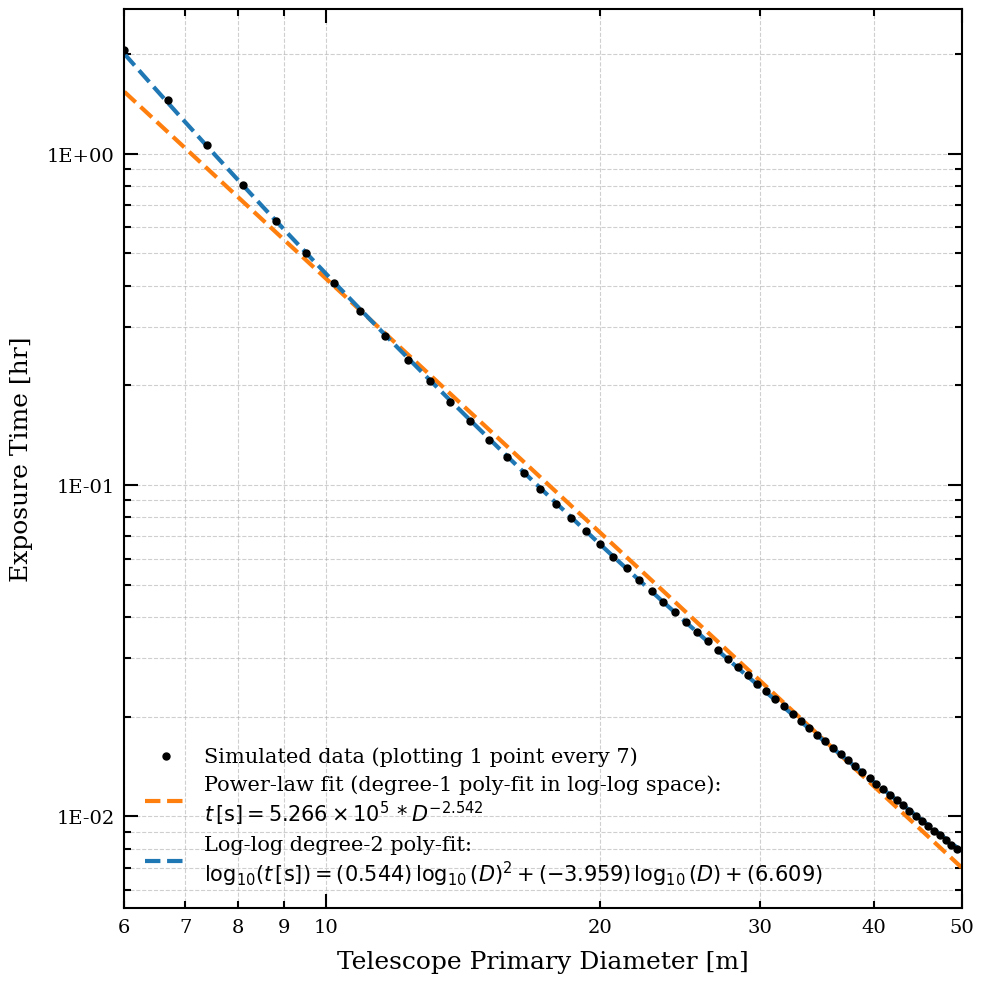

In [33]:
D = dataframe['D_m'].values.astype(float)
t = dataframe['t_exponent_s'].values.astype(float)

log10_D = np.log10(D)
log10_t = np.log10(t)

linear_fit = np.polyfit(log10_D, log10_t, deg=1)
slope = linear_fit[0]
intercept = 10.**linear_fit[1]

print(f"Degree-1 polynomial (power-law) fit: t_exposure [s] = {intercept:.3e} * D^{slope:.3f}")

D_fit = np.logspace(np.log10(D.min()), np.log10(D.max()), 500)
t_fit = intercept * D_fit**slope


a2, b2, c2 = np.polyfit(log10_D, log10_t, deg=2)

print(f"Log-log degree-2 polynomial fit: log10(t [s]) = ({a2:.3e})*(log10 D)^2 + ({b2:.3f})*log10 D + ({c2:.3f})")

log10_D_fit = np.log10(D_fit)
log10_t_fit_2 = a2*log10_D_fit**2. + b2*log10_D_fit + c2
t_fit_2 = 10.**log10_t_fit_2


plt.figure(figsize=(10,10))

step = 7
D_plot = D[::step]
t_plot = t[::step]
plt.scatter(D_plot, t_plot/ (60. * 60.), label=f"Simulated data (plotting 1 point every {step})", s=25., color='black', zorder=3)

exp = int(np.floor(np.log10(abs(intercept))))
mant = intercept / 10.**exp
plt.plot(D_fit, t_fit/ (60. * 60.), '--', color='C1', linewidth=3., label="Power-law fit (degree-1 poly-fit in log-log space):\n" rf"$t\, [\mathrm{{s}}] = {mant:.3f}\times10^{{{exp}}}\, * D^{{{slope:.3f}}}$")
plt.plot(D_fit, t_fit_2/ (60. * 60.), '--', color='C0', linewidth=3., label=f"Log-log degree-2 poly-fit:\n" rf"$\log_{{10}}\!\left(t\,[\mathrm{{s}}]\right)" rf" = ({a2:.3f})\,\log_{{10}}(D)^2" rf" + ({b2:.3f})\,\log_{{10}}(D)" rf" + ({c2:.3f})$")

plt.xlim(D.min(), D.max())
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Telescope Primary Diameter [m]", fontsize=18.)
plt.ylabel("Exposure Time [hr]", fontsize=18.)
#plt.title(f"Exposure Time vs Diameter: mV_exoworld = {mV_exoworld:.2f}, mV_star = {mV_star:.2f}", fontsize=20)

plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend(loc='lower left', fontsize=15.)

ax = plt.gca()

xmin = float(D.min())
xmax = float(D.max())

xt = [x for x in ax.get_xticks() if x >= xmin and x <= xmax]

if xmax not in xt:
    xt.append(xmax)

ax.set_xticks(sorted(set(xt)))

def plain_log_x(x, pos):
    if x < xmin or x <= 0.:
        return ""
    if abs(x - round(x)) < 1.e-10:
        return f"{int(round(x))}"
    return f"{x:g}"

ax.xaxis.set_major_formatter(FuncFormatter(plain_log_x))
ax.xaxis.set_minor_formatter(FuncFormatter(plain_log_x))

def sci_E(y, pos):
    if y <= 0.:
        return ""
    return f"{y:.0E}"

ax.yaxis.set_major_formatter(FuncFormatter(sci_E))
ax.yaxis.set_minor_formatter(NullFormatter())

ax.tick_params(axis='both', which='major', width=1.5, length=10., labelsize=14.)
ax.tick_params(axis='both', which='minor', width=1.5, length=5., labelsize=14.)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

##### Parameter tabulation

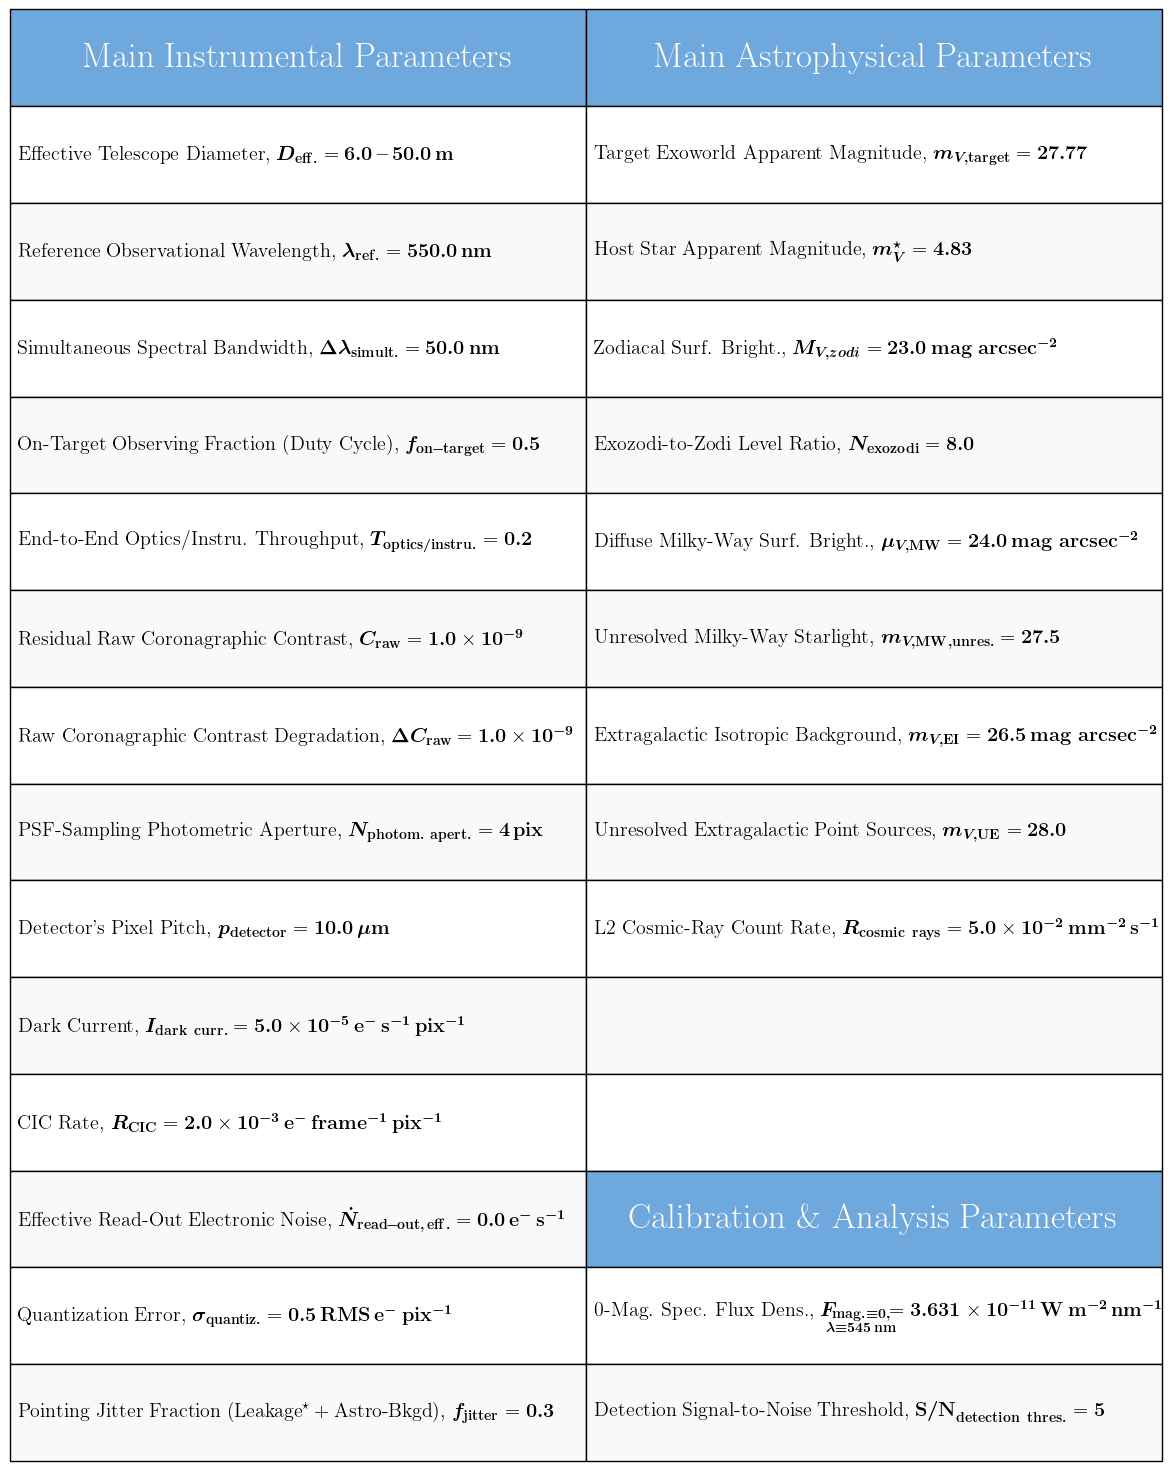

In [34]:
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')

if 'D_range_m' not in globals():
    D_range_m = np.array([D_m])

D_min = float(np.min(D_range_m))
D_max = float(np.max(D_range_m))

def sci_not(val):
    s = f"{val:.1e}"
    m, e = s.split('e')
    return m, int(e)

mantissa_dark, exponent_dark = sci_not(dark_current_electrons_s_1_pixel_1)
mantissa_CIC,  exponent_CIC  = sci_not(CIC_rate_electrons_frame_1_pixel_1)
mantissa_raw_C, exponent_raw_C = sci_not(residual_raw_C)
mantissa_raw_C_degradation, exponent_raw_C_degradation = sci_not(raw_C_degradation)

deep_space_cosmic_ray_count_rate_mm_2_s_1 = deep_space_cosmic_ray_count_rate_cm_2_s_1 * 1.e-2
mantissa_CR, exponent_CR = sci_not(deep_space_cosmic_ray_count_rate_mm_2_s_1)

pixel_pitch_um = pixel_pitch_cm * 1.e4

columns = [r"Main Instrumental Parameters", r"Main Astrophysical Parameters"]
calib_header_txt = r"Calibration \& Analysis Parameters"

data_rows = [
    [rf"Effective Telescope Diameter, $\boldsymbol{{D_{{\mathrm{{eff.}}}}}}=\boldsymbol{{{D_min:.1f}}}\,\boldsymbol{{\mathrm{{–}}}}\,\boldsymbol{{{D_max:.1f}}}\,\boldsymbol{{\mathrm{{m}}}}$", rf"Target Exoworld Apparent Magnitude, $\boldsymbol{{m_{{V,\mathrm{{target}}}}}}=\boldsymbol{{{mV_exoworld:.2f}}}$"],
    [rf"Reference Observational Wavelength, $\boldsymbol{{\lambda_{{\mathrm{{ref.}}}}}}=\boldsymbol{{{lam_nm:.1f}}}\,\boldsymbol{{\mathrm{{nm}}}}$", rf"Host Star Apparent Magnitude, $\boldsymbol{{m_V^\star}}=\boldsymbol{{{mV_star:.2f}}}$"],
    [rf"Simultaneous Spectral Bandwidth, $\boldsymbol{{\Delta\lambda_{{\mathrm{{simult.}}}}}}=\boldsymbol{{{dlam_nm:.1f}}}\,\boldsymbol{{\mathrm{{nm}}}}$", rf"Zodiacal Surf. Bright., $\boldsymbol{{M_{{V,zodi}}}}=\boldsymbol{{{mV_zodi_arcsec_2:.1f}}}\,\boldsymbol{{\mathrm{{mag~arcsec^{{-2}}}}}}$"],
    [rf"On-Target Observing Fraction (Duty Cycle), $\boldsymbol{{f_{{\mathrm{{on\kern-.07em-\kern-.07em target}}}}}}=\boldsymbol{{{duty_cycle:.1f}}}$", rf"Exozodi-to-Zodi Level Ratio, $\boldsymbol{{N_{{\mathrm{{exozodi}}}}}}=\boldsymbol{{{exozodi_factor:.1f}}}$"],
    [rf"End-to-End Optics/Instru. Throughput, $\boldsymbol{{T_{{\mathrm{{optics/instru.}}}}}}=\boldsymbol{{{end_to_end_throughput_optics_instrumentation:.1f}}}$", rf"Diffuse Milky-Way Surf. Bright., $\boldsymbol{{\mu_{{V,\mathrm{{MW}}}}}}=\boldsymbol{{{mV_MilkyWay_arcsec_2:.1f}}}\,\boldsymbol{{\mathrm{{mag~arcsec^{{-2}}}}}}$"],
    [rf"Residual Raw Coronagraphic Contrast, $\boldsymbol{{C_{{\mathrm{{raw}}}}}}=\boldsymbol{{{mantissa_raw_C}}}\times\boldsymbol{{10^{{{exponent_raw_C}}}}}$", rf"Unresolved Milky-Way Starlight, $\boldsymbol{{m_{{V,\mathrm{{MW,unres.}}}}}}=\boldsymbol{{{mV_unresolved_MW_starlight:.1f}}}$"],
    [rf"Raw Coronagraphic Contrast Degradation, $\boldsymbol{{\Delta C_{{\mathrm{{raw}}}}}}=\boldsymbol{{{mantissa_raw_C_degradation}}}\times\boldsymbol{{10^{{{exponent_raw_C_degradation}}}}}$", rf"Extragalactic Isotropic Background, $\boldsymbol{{m_{{V,\mathrm{{EI}}}}}}=\boldsymbol{{{mV_extragalactic_arcsec_2:.1f}}}\,\boldsymbol{{\mathrm{{mag~arcsec^{{-2}}}}}}$"],
    [rf"PSF-Sampling Photometric Aperture, $\boldsymbol{{N_{{\mathrm{{photom.\ apert.}}}}}}=\boldsymbol{{{N_pixels_photometric_aperture:.0f}}}\,\boldsymbol{{\mathrm{{pix}}}}$", rf"Unresolved Extragalactic Point Sources, $\boldsymbol{{m_{{V,\mathrm{{UE}}}}}}=\boldsymbol{{{mV_unresolved_extragalactic_point_sources:.1f}}}$"],
    [rf"Detector's Pixel Pitch, $\boldsymbol{{p_{{\mathrm{{detector}}}}}}=\boldsymbol{{{pixel_pitch_um:.1f}}}\,\boldsymbol{{\mu\mathrm{{m}}}}$", rf"L2 Cosmic-Ray Count Rate, $\boldsymbol{{R_{{\mathrm{{cosmic\ rays}}}}}}=\boldsymbol{{{mantissa_CR}}}\times\boldsymbol{{10^{{{exponent_CR}}}}}\,\boldsymbol{{\mathrm{{mm^{{-2}}\,s^{{-1}}}}}}$"],
    [rf"Dark Current, $\boldsymbol{{I_{{\mathrm{{dark\ curr.}}}}}}=\boldsymbol{{{mantissa_dark}}}\times\boldsymbol{{10^{{{exponent_dark}}}}}\,\boldsymbol{{\mathrm{{e^-\,s^{{-1}}\,pix^{{-1}}}}}}$", r""],
    [rf"CIC Rate, $\boldsymbol{{R_{{\mathrm{{CIC}}}}}}=\boldsymbol{{{mantissa_CIC}}}\times\boldsymbol{{10^{{{exponent_CIC}}}}}\,\boldsymbol{{\mathrm{{e^-\,frame^{{-1}}\,pix^{{-1}}}}}}$", r""],
    [rf"Effective Read-Out Electronic Noise, $\boldsymbol{{\dot{{N}}_{{\mathrm{{read\kern-.07em-\kern-.07em out,\,eff.}}}}}}=\boldsymbol{{{readout_noise_electrons_s_1:.1f}}}\,\boldsymbol{{\mathrm{{e^-\,s^{{-1}}}}}}$", calib_header_txt],
    [rf"Quantization Error, $\boldsymbol{{\sigma_{{\mathrm{{quantiz.}}}}}}=\boldsymbol{{{quantization_noise_RMSelectrons_pixel_1:.1f}}}\,\boldsymbol{{\mathrm{{RMS\,e^-\,pix^{{-1}}}}}}$", r"0-Mag. Spec. Flux Dens., $\boldsymbol{F_{\!\!\!\substack{\mathrm{mag.}\equiv0,\\\lambda\equiv545\,\mathrm{nm}}}}\!\!\!\!=\boldsymbol{3.631}\times\boldsymbol{10^{-11}}\,\boldsymbol{\mathrm{W\,m^{-2}\,nm^{-1}}}$"],
    [rf"Pointing Jitter Fraction $\left(\mathrm{{Leakage}}^\star + \mathrm{{Astro\text{{-}}Bkgd}}\right)$, $\boldsymbol{{f_{{\mathrm{{jitter}}}}}}=\boldsymbol{{{pointing_jitter_fraction:.1f}}}$", rf"Detection Signal-to-Noise Threshold, $\boldsymbol{{\mathrm{{S/N}}_{{\mathrm{{detection\ thres.}}}}}}=\boldsymbol{{{SNR_detection_threshold:.0f}}}$"],
]

scale = 1.2
fig, ax = plt.subplots(figsize=(12 * scale, len(data_rows) * .6 * scale))
ax.set_axis_off()

table = plt.table(
    cellText=data_rows,
    colLabels=columns,
    cellLoc='left',
    colLoc='left',
    loc='center',
    colWidths=[.5, .5],
    colColours=['#6fa8dc'] * 2,
)

table.auto_set_font_size(False)
table.set_fontsize(12. * scale)
row_h = .1 * scale

shift_cm = .5
shift_points = -shift_cm * 2.5 * 28.3465

for (r, c), cell in table.get_celld().items():

    if r == 0:

        cell.set_text_props(color='white', weight='bold', size=21 * scale)
        cell._loc = 'center'
        cell.get_text().set_ha('center')
        cell.get_text().set_va('center')

    cell.set_height(row_h)

    if r > 0:

        cell.set_facecolor('#f9f9f9' if r % 2 == 0 else 'white')

        text_obj = cell.get_text()
        is_calib_header_cell = (c == 1 and text_obj.get_text() == calib_header_txt)

        if is_calib_header_cell:
            cell.set_facecolor('#6fa8dc')
            cell.set_text_props(color='white', weight='bold', size=21. * scale)
            cell._loc = 'center'
            text_obj.set_ha('center')
            text_obj.set_va('center')
            text_obj.set_multialignment('center')
        else:
            text_obj.set_transform(
                text_obj.get_transform()
                + mtransforms.ScaledTranslation(shift_points / 72., 0., fig.dpi_scale_trans)
            )

plt.subplots_adjust(left=.1, right=.9, top=.9, bottom=.1)
plt.show()

#### Nancy Grace Roman Space Telescope

In [35]:
# Telescopic parameters | Nancy Grace Roman Space Telescope
# Reference: https://roman.gsfc.nasa.gov/science/observatory_technical.html

D_m_after_aperture_stop = 2.36    # Primary mirror diameter after the aperture stop
relative_central_obscuration = 0.303    # Linear obscuration of the telescope's entrance pupil; diameter ratio
blocked_area_fraction = relative_central_obscuration**2.
A_m2 = diameter_to_area(D_m_after_aperture_stop) * (1. - blocked_area_fraction)    # Effective light-gathering area
D_m = area_to_diameter(A_m2)


print(f"Nancy Grace Roman Space Telescope's effective light-gathering area: A_m2 = {A_m2:.6f} m^2")

Nancy Grace Roman Space Telescope's effective light-gathering area: A_m2 = 3.972749 m^2


#### 4 m

In [36]:
# Telescopic parameters

#D_m = 4.    # Primary mirror diameter
#A_m2 = diameter_to_area(D_m)    # Light-gathering area

#### 12 m

In [37]:
# Telescopic parameters

#D_m = 12.    # Primary mirror diameter
#A_m2 = diameter_to_area(D_m)    # Light-gathering area

#### 25 m

In [38]:
# Telescopic parameters

#D_m = 25.    # Primary mirror diameter
#A_m2 = diameter_to_area(D_m)    # Light-gathering area

#### 50 m

In [39]:
# Telescopic parameters

D_m = 50.    # Primary mirror diameter
A_m2 = .8 * diameter_to_area(D_m)    # Light-gathering area diffraction-limited over 20+ years according to Gabay+2025